In [16]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import json
import multiprocessing
import time

In [17]:
# εισαγωγή αρχείου KML
tree = ET.parse('agios_atha.kml')
root = tree.getroot()

In [18]:
# δημιουργώ κενό 2d  πίνακα
arr = np.empty((0,2))

# Το {http://www.opengis.net/kml/2.2} χρησιμοποιέιται για να ορίσεις την δομή και την διαδρομή του στοιχείου
# Ουσιαστικά δημιουργεί αντικείμενο επαναλήπτη που κάνει επαν΄αληψη για κάθε στοιχείο "Placemerk"
for i,placemark in enumerate(root.iter('{http://www.opengis.net/kml/2.2}Placemark')):
    # Εξαγωγή στοιχείων από το αρχείο
    # η συνάρτηση .find() χρησιμοποιείται για να πάρεις τις συντεταγμένες απο την διαδρομή point/coordinates
    coordinates = placemark.find('{http://www.opengis.net/kml/2.2}Point/{http://www.opengis.net/kml/2.2}coordinates').text
    
    # Προσθήκη x,y συντεταγμένων στον πίνακα
    # η συνάρτηση split επιστρέφει έναν πίνακα για όλα τα στοιχεία που έχουμε χωρίσει
    # χρησιμοποιούμε ξανά την split για το κενό και πάιρνουμε το τελευτείο στοιχείο
    x = float(coordinates.split(',')[0].split(" ")[-1])
    y = float(coordinates.split(',')[1])
    arr = np.append(arr,[[x,y]],axis=0)

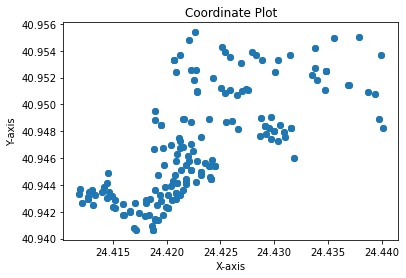

In [19]:
# Σχεδιάγραμμα στοιχείων
plt.scatter(arr[:,0],arr[:,1])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Coordinate Plot')
plt.show()

In [20]:
def path_lenght(array):
    # Υπλογίζουμε τις διαφο΄ρες μεταξύ συνεχόμενων σημείων 
    differences = np.diff(array, axis=0)  
    # Υπολογίζουμε ευκλείδιες αποστάσεις
    distances = np.linalg.norm(differences, axis=1)  
    # Αθροίζουμε τις αποστάσεις
    length = np.sum(distances)  
    # Προσθέτουμε τις αποστάσεις μεταξύ των πρώτου και τελευταίου σημείου 
    length += np.linalg.norm(array[-1] - array[0])  
    return length

def distance_matrix(points):
    # υπολογίζουμε ευκλείδιες αποστάσεις μεταξύ όλων των σημείων
    dist_mat = np.linalg.norm(points[:, np.newaxis] - points, axis=-1)
    return dist_mat


def inverse_distance_matrix(points):
    points_size = points.shape[0]
    
    # Calculate distance matrix using vectorized operations
    dist_mat = np.linalg.norm(points[:, np.newaxis] - points, axis=-1)
    
    # Δημιουργήστε έναν πίνακα ταυτότητας και υπολογίστε τις αντίστροφες αποστάσεις
    # np.where(condition,x,y)
    # np.eye is true at diag.
    # when cond is true, it assigns 0.0
    
    # θέτω την διαγώνιο με 0.0 καθως d(a,a) πάντα είναι 0
    inv_dist_mat = np.where(np.eye(points_size, dtype=bool), 0.0, 1.0 / dist_mat)
    
    return inv_dist_mat

<AxesSubplot:>

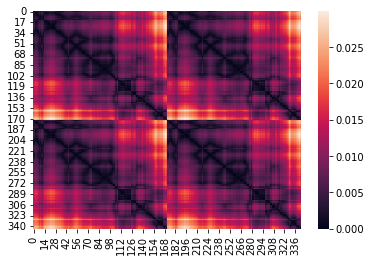

In [22]:
# εμφανίζω τον πίνακα αποστάσεων
dist_map = distance_matrix(arr)
sns.heatmap(dist_map)

C:\Users\DIMITRIS\AppData\Local\Temp\ipykernel_18224\3530588518.py:30: RuntimeWarning: divide by zero encountered in divide
  inv_dist_mat = np.where(np.eye(points_size, dtype=bool), 0.0, 1.0 / dist_mat)


<AxesSubplot:>

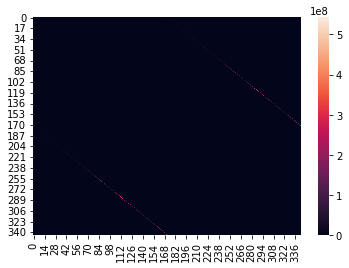

In [23]:
# εμφανίζω πίνακα αντρίστροφν αποστάσεων
inv_dist_mat = inverse_distance_matrix(arr)
sns.heatmap(inv_dist_mat)

In [24]:
class Ant:
    def __init__(self, n_locations):
        # μεταβλητές του κάθε μυρμηγκιού
        self.n_locations = n_locations
        self.position = np.random.choice(n_locations)
        
        self.places_visited = [self.position]
        self.places_left = list(np.arange(n_locations))
        self.places_left.remove(self.position)
        
        self.phero_graph = np.full((n_locations,n_locations),0.0)
        self.tour_cost = 0.0

    def ant_trip(self, g_phero_graph, dist_mat, inv_dist_mat, alpha=1, beta=1, Q=1):
        for _ in range(len(self.places_left)):
            # vectorized operations
            #υπολογίζω την πιθανότητες για την επόμενη κίνηση
            allowed_weights = (g_phero_graph[self.position, self.places_left] ** alpha) * (inv_dist_mat[self.position, self.places_left] ** beta)
            allowed_weights_sum = np.sum(allowed_weights)
            travel_probas = allowed_weights / allowed_weights_sum
            
            # τυχάια επιλογή επόμενου σημείου
            next_destination = np.random.choice(self.places_left, p=travel_probas)

            # προσθέτω την απόσταση που διανυθηκε στην συνολική
            self.tour_cost += dist_mat[self.position, next_destination]
            
            # ενημερώνω τα δεδομένα, μετακινο΄ύμαι
            self.position = next_destination
            self.places_visited.append(next_destination)
            self.places_left.remove(next_destination)
            
        # ενημέρωση πίνακα φερομόνης
        for i, j in zip(self.places_visited[:-1], self.places_visited[1:]):
            self.phero_graph[i, j] = Q / self.tour_cost

    def ant_flush(self):
        
        self.position = np.random.choice(self.n_locations)
        self.places_visited = [self.position]
        self.places_left = list(np.arange(self.n_locations))
        
        self.phero_graph = np.full((self.n_locations,self.n_locations),0.0)
        self.places_left.remove(self.position)
        self.tour_cost = 0.0


In [25]:
def update_pheromones(g_phero_graph, ants, evapo_coef=0.05):
    # πολλαπλασιάζω τον πίνακα με τον πίνακα φερομόνης
    evaporation_component = (1 - evapo_coef) * g_phero_graph
    # αθροίζω τις φερομόνες απο όλα τα μυρμήγκια
    deposition_component = np.sum([ant.phero_graph for ant in ants], axis=0)
    # συνζιάζω τυος 2 πίνακες
    new_pheromones = evaporation_component + deposition_component
    # ελενχω είναι κάτω απο 1e-08 για να μην δημιουργούνται αριθμητικά λάθη
    new_pheromones = np.maximum(new_pheromones, 1e-08)
    return new_pheromones


In [26]:
def aco(points, alpha, beta, evapo_coef, colony_size, num_iter):
    # υπολογίζω τις αποστάσεις
    dist_mat = distance_matrix(points)
    inv_dist_mat = inverse_distance_matrix(points)
    
    n_locations = points.shape[0]  # συνολικός αριθμός σημείων
    ants = [Ant(n_locations) for _ in range(colony_size)]  # initialize ants
    
    # υπολογισμός αρχικης φερομόνης
    phero_init = (inv_dist_mat.mean())**(beta / alpha)
    g_phero_graph = np.full((n_locations, n_locations), phero_init)  # Πίνκας φερομόνης
    
    # Υπολογίζω "Q"
    [ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, alpha, beta, Q=1) for ant in ants]
    best_ant_idx = np.argmin([ant.tour_cost for ant in ants])  # ευρεση καλύτερου μυργμηγκιού
    Q = ants[best_ant_idx].tour_cost * phero_init / (0.1 * colony_size)
    print(Q)
    
    best_path_length = ants[best_ant_idx].tour_cost
    best_path = ants[best_ant_idx].places_visited
    
    monitor_costs = []
    
    for _ in tqdm(range(num_iter)):
        [ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, alpha, beta, Q) for ant in ants]  # μυργμήγια κάνουν τις διαδρομές 
        g_phero_graph = update_pheromones(g_phero_graph, ants, evapo_coef)  # Ενημερώνω πίνακας φερομόνης 
        
        iteration_winner_idx = np.argmin([ant.tour_cost for ant in ants])  # Βρίσκω το καλύτερο μυργμήκγι
        best_path_iteration = ants[iteration_winner_idx].places_visited
        
        # Ενημέρωση ολικού μεγίστου
        if best_path_length > ants[iteration_winner_idx].tour_cost:
            best_ant_idx = iteration_winner_idx
            best_path = best_path_iteration
            best_path_length = ants[iteration_winner_idx].tour_cost

            
        monitor_costs.append(best_path_length)
        
        [ant.ant_flush() for ant in ants]  # Επαναφορά μυργμιγκιων
    
    return best_path, monitor_costs


In [27]:
monitor = []


best_path, monitor_costs = aco(points = arr, 
                               alpha = 1, 
                               beta = 1, 
                               evapo_coef = 0.2, 
                               colony_size = 75, 
                               num_iter = 100)





print(monitor_costs[-1])
print('')

plt.figure(figsize=(20,5));
plt.subplot(1,2,1);
plt.plot(arr[best_path,0],
         arr[best_path,1]);


plt.subplot(1,2,2);
plt.plot(np.arange(len(monitor_costs)),monitor_costs);

C:\Users\DIMITRIS\AppData\Local\Temp\ipykernel_18224\3530588518.py:30: RuntimeWarning: divide by zero encountered in divide
  inv_dist_mat = np.where(np.eye(points_size, dtype=bool), 0.0, 1.0 / dist_mat)


25059.679514691947


  1%|          | 1/100 [00:02<04:27,  2.70s/it]


KeyboardInterrupt: 

0.4987325232182914



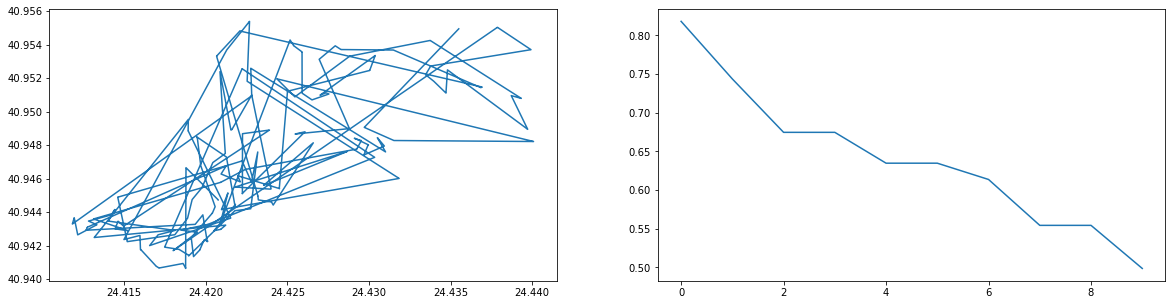

In [4]:
# load results

# Load the JSON file
with open("save_file.json", "r") as file:
    data = json.load(file)

# Extract the 'monitor_costs' from the loaded data
monitor_costs = data['monitor_costs']
best_path = data['best_path']

print(monitor_costs[-1])
print('')

plt.figure(figsize=(20,5));
plt.subplot(1,2,1);
plt.plot(arr[best_path,0],
         arr[best_path,1]);


plt.subplot(1,2,2);
plt.plot(np.arange(len(monitor_costs)),monitor_costs);


In [ ]:
#save results


monitor_costs = [cost for cost in monitor_costs]
best_path = [int(point) for point in best_path]

# Save variables to a file
data = {'monitor_costs': monitor_costs, 'best_path': best_path}
with open('save_file.json', 'w') as file:
    json.dump(data, file)